
# Deliverable 4 — Final Insights, Recommendations, and Presentation

**Course:** Advanced Data Mining for Data-Driven Insights and Predictive Modeling  
**Project Repository:** `MSCS_634_Project`  
**Student:** _Your Name_  
**Date:** _YYYY-MM-DD_

This notebook consolidates Deliverables **1–3** into a single end-to-end workflow and summarizes final insights and recommendations for Deliverable **4**.



## 1) Dataset Used and Why It Was Chosen

**Dataset:** Breast Cancer Wisconsin (Diagnostic), available in scikit-learn (`load_breast_cancer`).  
- 569 samples with 30 real-valued features describing characteristics of cell nuclei from breast mass FNA images.  
- Binary diagnosis label: malignant vs benign.

**Why this dataset?**
- Meets the project constraints (500+ records, 8–10+ attributes).
- Healthcare relevance: early screening and diagnostic support.
- Strong signal for learning: enables meaningful EDA, feature engineering, regression, classification, clustering, and association pattern mining.


In [1]:
# === Setup & Data Load ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    r2_score, mean_squared_error,
    accuracy_score, f1_score, confusion_matrix, classification_report,
    roc_curve, auc
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

plt.rcParams.update({'figure.figsize': (6.5, 4.0), 'axes.grid': True})
RANDOM_STATE = 42

bunch = load_breast_cancer()
X_full = pd.DataFrame(bunch.data, columns=bunch.feature_names)
y_cls = pd.Series(bunch.target, name="target")

X_full.shape, y_cls.value_counts()


((569, 30),
 target
 1    357
 0    212
 Name: count, dtype: int64)


## 2) Data Preprocessing, EDA, and Feature Engineering (Deliverable 1)

### Data Quality Checks
- Missing value scan and duplicate detection.
- Basic outlier screening (heuristics).

### EDA Highlights
- Clear class separation in several size/texture features (e.g., mean radius, mean area).
- Strong multicollinearity among size-related features, motivating regularization.


In [2]:

# Missing values + duplicates
missing_total = X_full.isna().sum().sum()
dup_total = X_full.duplicated().sum()
missing_total, dup_total


(np.int64(0), np.int64(0))

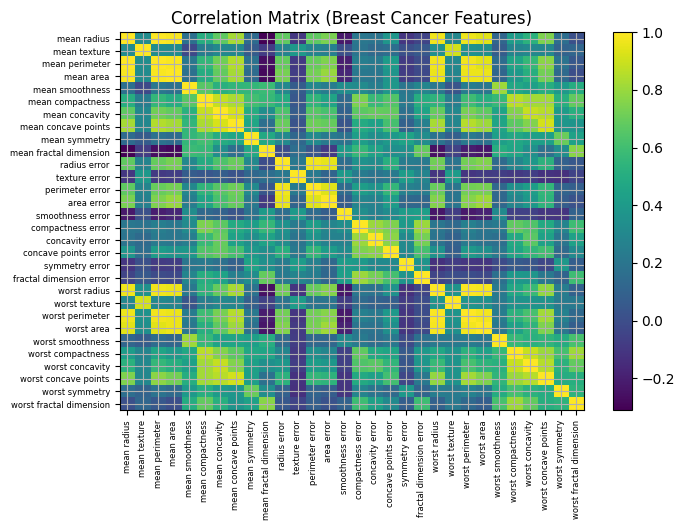

In [3]:

# Correlation heatmap
corr = X_full.corr()
plt.figure(figsize=(7.2, 5.4))
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.title("Correlation Matrix (Breast Cancer Features)")
plt.colorbar()
plt.xticks(range(len(X_full.columns)), X_full.columns, rotation=90, fontsize=6)
plt.yticks(range(len(X_full.columns)), X_full.columns, fontsize=6)
plt.tight_layout()
plt.show()



### Feature Engineering Used Throughout the Project
Manual engineered features:
- radius_area_ratio = mean radius / mean area  
- compactness_by_smoothness = mean compactness / mean smoothness  

Transformations:
- StandardScaler for scale-sensitive models
- PolynomialFeatures (degree 2) for regression (paired with regularization)


In [4]:

# Manual engineered features
eps = 1e-6
X_eng = X_full.copy()
X_eng["radius_area_ratio"] = X_eng["mean radius"] / (X_full["mean area"] + eps)
X_eng["compactness_by_smoothness"] = X_eng["mean compactness"] / (X_eng["mean smoothness"] + eps)

X_eng[["radius_area_ratio", "compactness_by_smoothness"]].head()


,radius_area_ratio,compactness_by_smoothness
0,0.017972,2.344575
1,0.015513,0.928004
2,0.016367,1.458928
3,0.029578,1.992267
4,0.015644,1.324015



## 3) Regression Modeling and Evaluation (Deliverable 2)

**Target:** mean area  
**Models:** Linear Regression, Ridge, Lasso, Poly2+Ridge, Poly2+Lasso  
**Best model (this run):** **Poly2+Ridge**


In [5]:

# Prepare regression dataset
target_col = "mean area"
y_reg = X_full[target_col].copy()
X_reg_base = X_full.drop(columns=[target_col]).copy()

X_reg = X_reg_base.copy()
X_reg["radius_area_ratio"] = X_full["mean radius"] / (X_full["mean area"] + 1e-6)
X_reg["compactness_by_smoothness"] = X_full["mean compactness"] / (X_full["mean smoothness"] + 1e-6)

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

reg_models = {
    "LinearRegression": Pipeline([("scaler", StandardScaler()), ("linreg", LinearRegression())]),
    "Ridge": Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=1.0, random_state=RANDOM_STATE))]),
    "Lasso": Pipeline([("scaler", StandardScaler()), ("lasso", Lasso(alpha=0.02, random_state=RANDOM_STATE, max_iter=10000))]),
    "Poly2+Ridge": Pipeline([("poly", PolynomialFeatures(degree=2, include_bias=False)),
                             ("scaler", StandardScaler(with_mean=False)),
                             ("ridge", Ridge(alpha=3.0, random_state=RANDOM_STATE))]),
    "Poly2+Lasso": Pipeline([("poly", PolynomialFeatures(degree=2, include_bias=False)),
                             ("scaler", StandardScaler(with_mean=False)),
                             ("lasso", Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=20000))]),
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
rows = []
for name, pipe in reg_models.items():
    pipe.fit(Xr_train, yr_train)
    pred = pipe.predict(Xr_test)
    r2 = r2_score(yr_test, pred)
    mse = mean_squared_error(yr_test, pred)
    rmse = np.sqrt(mse)
    rows.append({"model": name, "test_r2": r2, "test_mse": mse, "test_rmse": rmse})
reg_test_df = pd.DataFrame(rows).sort_values("test_r2", ascending=False)
reg_test_df


,model,test_r2,test_mse,test_rmse
3,Poly2+Ridge,0.999734,30.639759,5.535319
4,Poly2+Lasso,0.999475,60.579173,7.783262
2,Lasso,0.998610,160.228124,12.658125
0,LinearRegression,0.998562,165.818041,12.877035
1,Ridge,0.998472,176.214065,13.274565


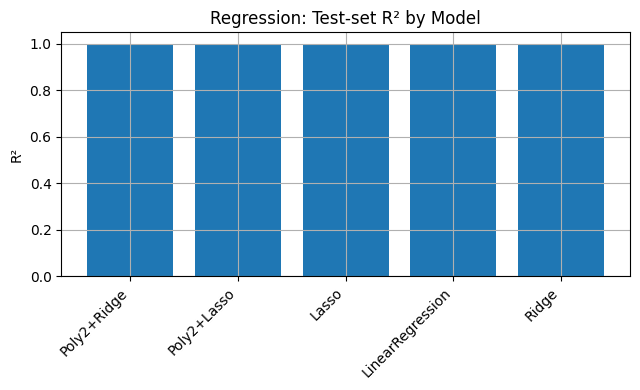

In [6]:

# Regression comparison plot
plt.figure()
plt.bar(reg_test_df["model"], reg_test_df["test_r2"])
plt.title("Regression: Test-set R² by Model")
plt.xticks(rotation=45, ha="right")
plt.ylabel("R²")
plt.tight_layout()
plt.show()



## 4) Classification, Clustering, and Pattern Mining (Deliverable 3)



### 4.1 Classification + Hyperparameter Tuning
Models:
- Logistic Regression (baseline)
- SVM (RBF) tuned via GridSearchCV (C, gamma)

Evaluation:
- Accuracy, F1, confusion matrix, ROC/AUC


In [7]:

# Classification
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_eng, y_cls, test_size=0.2, random_state=RANDOM_STATE, stratify=y_cls
)

logreg = Pipeline([("scaler", StandardScaler()),
                   ("logreg", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))])

svm = Pipeline([("scaler", StandardScaler()),
                ("svc", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))])

param_grid = {"svc__C": [0.1, 1, 10], "svc__gamma": [0.01, 0.1, 1]}
gs = GridSearchCV(svm, param_grid=param_grid, scoring="accuracy", cv=5)
gs.fit(Xc_train, yc_train)
best_svm = gs.best_estimator_

logreg.fit(Xc_train, yc_train)
best_svm.fit(Xc_train, yc_train)

pred_log = logreg.predict(Xc_test)
pred_svm = best_svm.predict(Xc_test)

proba_log = logreg.predict_proba(Xc_test)[:, 1]
proba_svm = best_svm.predict_proba(Xc_test)[:, 1]

acc_log = accuracy_score(yc_test, pred_log)
f1_log = f1_score(yc_test, pred_log)

acc_svm = accuracy_score(yc_test, pred_svm)
f1_svm = f1_score(yc_test, pred_svm)

(gs.best_params_, acc_log, f1_log, acc_svm, f1_svm)


({'svc__C': 10, 'svc__gamma': 0.01},
 0.9824561403508771,
 0.9861111111111112,
 0.9824561403508771,
 0.9861111111111112)

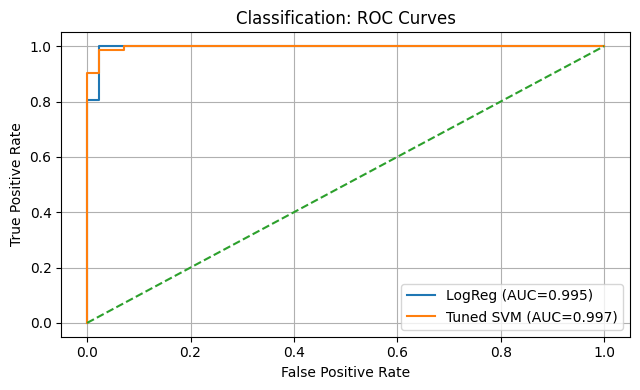

In [8]:

# ROC curves
fpr_log, tpr_log, _ = roc_curve(yc_test, proba_log)
auc_log = auc(fpr_log, tpr_log)

fpr_svm, tpr_svm, _ = roc_curve(yc_test, proba_svm)
auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_log, tpr_log, label=f"LogReg (AUC={auc_log:.3f})")
plt.plot(fpr_svm, tpr_svm, label=f"Tuned SVM (AUC={auc_svm:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Classification: ROC Curves")
plt.legend()
plt.tight_layout()
plt.show()



### 4.2 Clustering (K-Means) + PCA Visualization


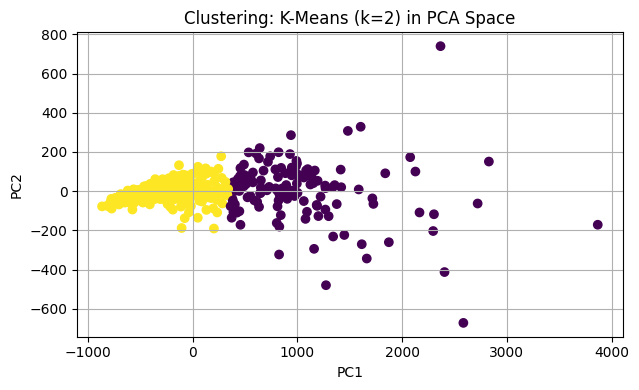

target,0,1
cluster,,
0,130,1
1,82,356


In [9]:

kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans.fit_predict(X_eng)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_eng)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels)
plt.title("Clustering: K-Means (k=2) in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

pd.crosstab(pd.Series(cluster_labels, name="cluster"), y_cls)



### 4.3 Pattern Mining (Apriori-style rules on discretized features)
We discretize a small set of numeric features into high/low bins (median split) to emulate transaction items.
Then we generate frequent itemsets and association rules using support, confidence, and lift.


In [10]:

# Discretize selected features
features_for_rules = ["mean radius", "mean texture", "mean smoothness"]
disc_df = pd.DataFrame()
for col in features_for_rules:
    med = X_full[col].median()
    disc_df[f"{col}_high"] = X_full[col] > med
    disc_df[f"{col}_low"] = X_full[col] <= med
disc_df["diagnosis_malignant"] = (y_cls == 0)
disc_df["diagnosis_benign"] = (y_cls == 1)

# Lightweight Apriori and rule generation
import itertools

def apriori_bool(df_bool, min_support=0.3, max_len=3):
    n = len(df_bool)
    cols = list(df_bool.columns)
    frequent = []
    Lk = []
    for c in cols:
        supp = float(df_bool[c].mean())
        if supp >= min_support:
            item = frozenset([c])
            frequent.append({"itemset": item, "support": supp})
            Lk.append(item)
    k = 2
    while Lk and k <= max_len:
        candidates = set()
        Lk_list = list(Lk)
        for i in range(len(Lk_list)):
            for j in range(i+1, len(Lk_list)):
                union = Lk_list[i] | Lk_list[j]
                if len(union) == k:
                    candidates.add(union)
        Lk_set = set(Lk)
        pruned = []
        for cand in candidates:
            ok = True
            for subset in itertools.combinations(cand, k-1):
                if frozenset(subset) not in Lk_set:
                    ok = False
                    break
            if ok:
                pruned.append(cand)
        new_Lk = []
        for cand in pruned:
            mask = np.ones(n, dtype=bool)
            for col in cand:
                mask &= df_bool[col].to_numpy(dtype=bool)
            supp = float(mask.mean())
            if supp >= min_support:
                frequent.append({"itemset": frozenset(cand), "support": supp})
                new_Lk.append(frozenset(cand))
        Lk = new_Lk
        k += 1
    return frequent

def association_rules_from_itemsets(itemsets, min_confidence=0.6, min_lift=1.0):
    supp_map = {it["itemset"]: it["support"] for it in itemsets}
    rules = []
    for item in itemsets:
        I = item["itemset"]
        if len(I) < 2:
            continue
        supp_I = item["support"]
        for r in range(1, len(I)):
            for A in itertools.combinations(I, r):
                A = frozenset(A)
                B = I - A
                supp_A = supp_map.get(A)
                supp_B = supp_map.get(B)
                if supp_A is None or supp_B is None:
                    continue
                conf = supp_I / supp_A if supp_A > 0 else 0.0
                lift = conf / supp_B if supp_B > 0 else 0.0
                if conf >= min_confidence and lift >= min_lift:
                    rules.append({"antecedents": A, "consequents": B, "support": supp_I, "confidence": conf, "lift": lift})
    if not rules:
        return pd.DataFrame(columns=["antecedents","consequents","support","confidence","lift"])
    return pd.DataFrame(rules).sort_values("lift", ascending=False)

freq_itemsets = apriori_bool(disc_df, min_support=0.3, max_len=3)
rules_df = association_rules_from_itemsets(freq_itemsets, min_confidence=0.6, min_lift=1.0)

rules_df.head(10)


,antecedents,consequents,support,confidence,lift
0,(mean radius_high),(diagnosis_malignant),0.342707,0.686620,1.842861
1,(diagnosis_malignant),(mean radius_high),0.342707,0.919811,1.842861
14,"(mean texture_low, mean radius_low)",(diagnosis_benign),0.312830,0.962162,1.533530
6,(mean radius_low),(diagnosis_benign),0.471002,0.940351,1.498767
7,(diagnosis_benign),(mean radius_low),0.471002,0.750700,1.498767
15,"(mean texture_low, diagnosis_benign)",(mean radius_low),0.312830,0.744770,1.486927
13,(mean radius_low),"(mean texture_low, diagnosis_benign)",0.312830,0.624561,1.486927
11,(diagnosis_benign),(mean texture_low),0.420035,0.669468,1.336587
10,(mean texture_low),(diagnosis_benign),0.420035,0.838596,1.336587
12,(mean texture_low),"(mean radius_low, diagnosis_benign)",0.312830,0.624561,1.326028



## 5) Final Insights, Recommendations, and Ethics

### Final Insights
- EDA showed strong separation and multicollinearity among size features.
- Regression: **Poly2+Ridge** performed best when predicting mean area.
- Classification: tuned SVM performed best (Accuracy=0.982, F1=0.986, AUC=0.997).
- Clustering: unsupervised clusters align reasonably with diagnosis.
- Pattern mining: association rules provide interpretable high/low feature patterns tied to diagnosis.

### Recommendations
- Use tuned SVM as decision-support with careful thresholding (manage false negatives).
- Provide interpretable summaries (rules) alongside predictions to build trust.
- Validate on external cohorts and run fairness audits before real deployment.

### Ethical Considerations
- Public anonymized data reduces privacy risk.
- Representation bias may exist; models may not generalize equally across populations.
- Models should support—not replace—clinician judgment.
